# 置换检验 permutation test

permutation test 使用了非参数检验的一个广泛套路，即原假设成立情况下两分布相同，如wilcoxon秩和检验也是这样处理的。

置换检验一般也用来检验均值(wilcoxon秩和检验本身是检验中位数的，当然对称的时候中位数就是均值，不过wilcoxon秩和不要求对称，
wilcoxon signrank才需要。)

置换检验有一个面向双样本的统计量（比如两样本均值的差）$S$，以及一个总体分布$F$和两个样本规模$m,n$。检验统计量是分层的，
其有$m+n$个参数，都是独立服从分布$F$的随机变量。任一个参数排列可以通过$S$取到的值，都为统计量可以取到的值，且概率为取到该
值的排列数占总排列数的比例。

检验中取$m=1,n=0$时（虽说面向双样本，其实给定$m,n$后也只不过是$m+n$个观测的一种有规律的组合方式而已）。把$S$搞成恒等映射，
则最后检验统计量就是个服从分布$F$的随机变量而已。注意它是可能是连续，并不因为它最后搞了一个离散分配就不可能连续了。

在给定$m+n$个随机参数的一组赋值的条件后，检验统计量从分层的随机变量退化成一个离散随机变量。
如给定条件为$1,2;3$和均值差统计量则“生成”（条件化得到）的离散随机变量为

$$
\begin{bmatrix}
-1.5 & 0  &  1.5 \\
1/3  & 1/3 &  1/3
\end{bmatrix}
$$

这是因为

$$
1,2;3 \to 1.5 - 3 = -1.5 \\
1,3;2 \to 2 - 2 = 0 \\
2,1;3 \to 1.5 - 3 = -1.5 \\
2,3;1 \to 2.5 - 1 = 1.5 \\
3,1;2 \to 2 - 2 = 0 \\
3,2;1 \to 2.5 - 1 = 1.5
$$

理论上，我们可以上法穷举所有排列来定出精确的离散分布。但阶乘的复杂度感人，于是我们转而采用随机生成一堆排列并计算统计量的方式。

In [1]:
sample(c(1,2,3,4)) # draw a random full permutation

[1] 2 4 1 3

In [2]:
salary1 <- c(6864, 7304, 7477, 7779, 7895, 8348, 8461,9553, 9919, 10073, 10270,
             11581, 13472, 13600, 13962, 15019, 17244)
salary2 <- c(10276, 10533, 10633, 10837, 11209, 11393, 11864, 12040, 12642,
             12675, 13199, 13683, 14049, 14061, 16079)


In [12]:
m <- length(salary1)
n <- length(salary2)
S <- function(a1,a2){
    mean(a1) - mean(a2)
}

salary <- c(salary1,salary2)
res <- c()
for(i in 1:1000){
    permu <- sample(salary)
    res <- c(res,S(permu[1:m],permu[(m+1):(m+n)]))
}

In [14]:
head(res)

[1]  314.00000   89.12157  733.89020  561.34118 1040.46275 -263.63137

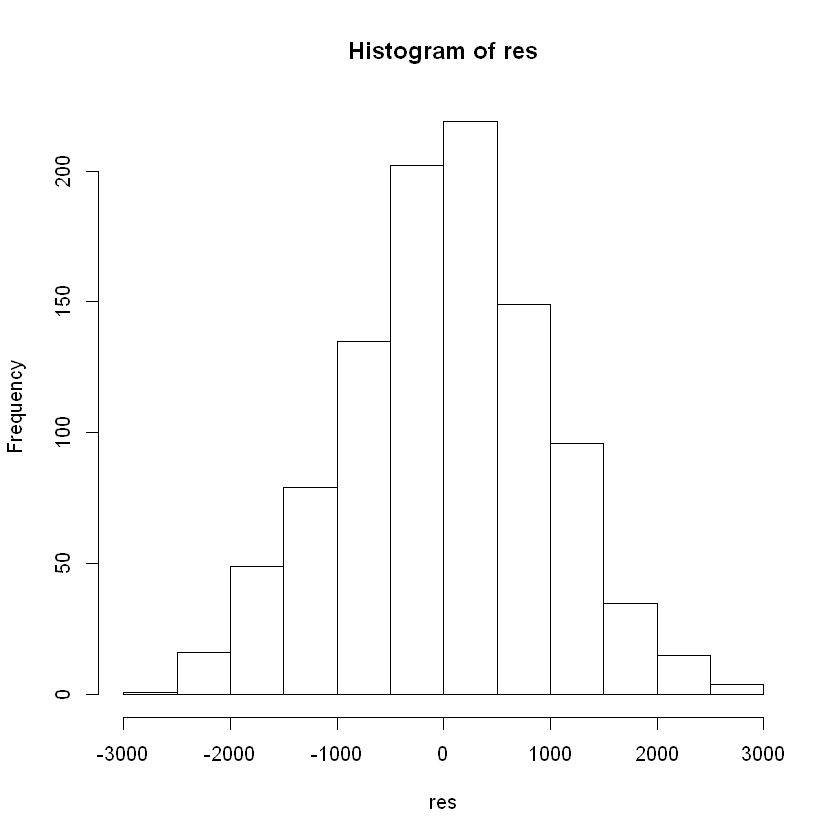

In [15]:
hist(res)

In [18]:
obs <- mean(salary[1:m])-mean(salary[(m+1):(m+n)])
obs

[1] -1825.984

In [20]:
sum(res<obs)/length(res)

[1] 0.03

这个相当于左扫尾p值为0.03的结果。如果构造左侧0.05水平检验就可以拒绝均值相等假设了。我们还可以轻松用它做一些其他检验，
比如方差差（终于不必是“比”了）是否相同。

In [22]:
var(salary1)

[1] 9657197

In [23]:
var(salary2)

[1] 2699857

In [30]:
permutation.test <- function(d1, d2, S, size = 1000, hist = TRUE){
    m <- length(d1)
    n <- length(d2)
    d <- c(d1,d2)
    res <- c()
    for(i in 1:size){
        permu <- sample(d)
        res <- c(res, S(permu[1:m],permu[(m+1):(m+n)]))
    }
    if(hist){
        hist(res)
    }
    obs <- S(d1,d2)
    left.p <- sum(res<obs)/size
    right.p <- sum(res>obs)/size
    return(list(statistic = obs ,left.p = left.p, right.p = right.p))
}

$statistic
[1] -1825.984

$left.p
[1] 0.03

$right.p
[1] 0.97

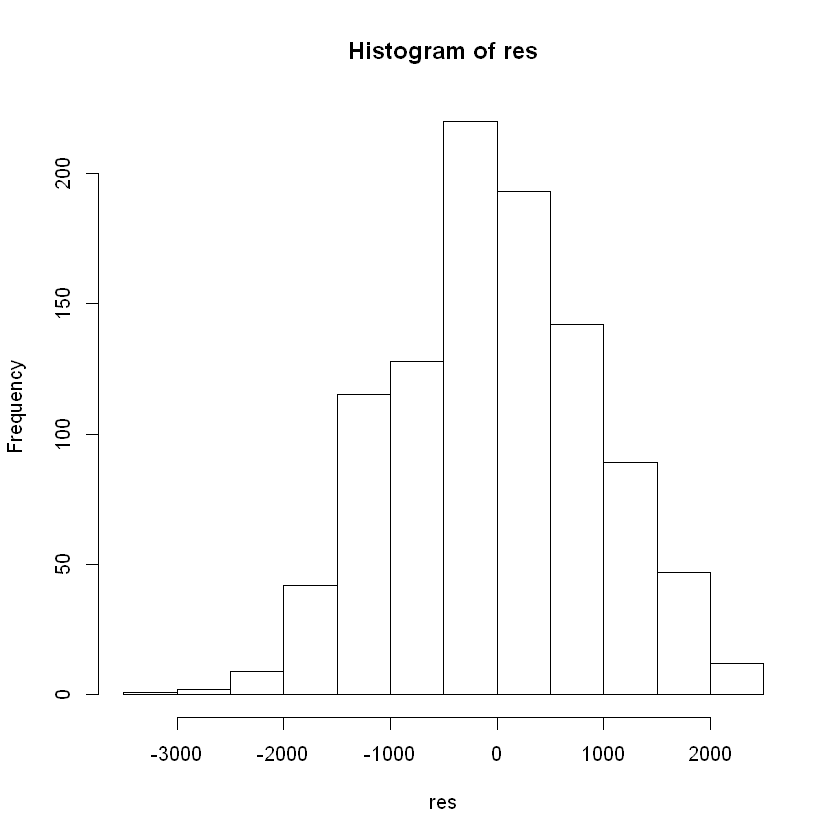

In [31]:
permutation.test(salary1, salary2, function(d1,d2){mean(d1)-mean(d2)})

$statistic
[1] 6957340

$left.p
[1] 0.991

$right.p
[1] 0.009

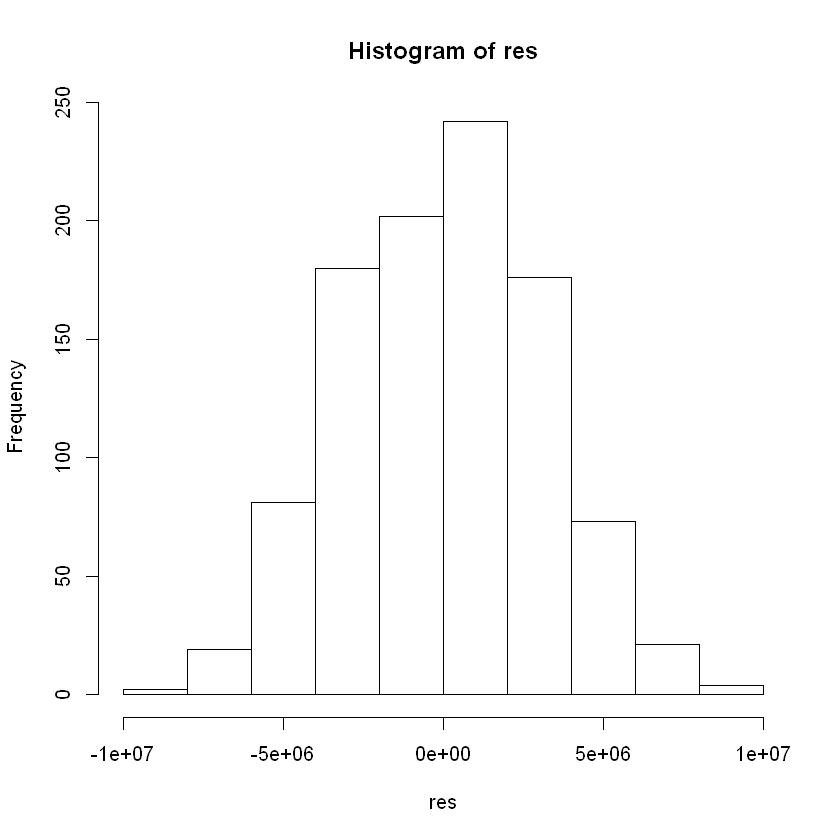

In [34]:
permutation.test(salary1, salary2, function(d1,d2){var(d1)-var(d2)})

$statistic
[1] 3.576929

$left.p
[1] 0.997

$right.p
[1] 0.003

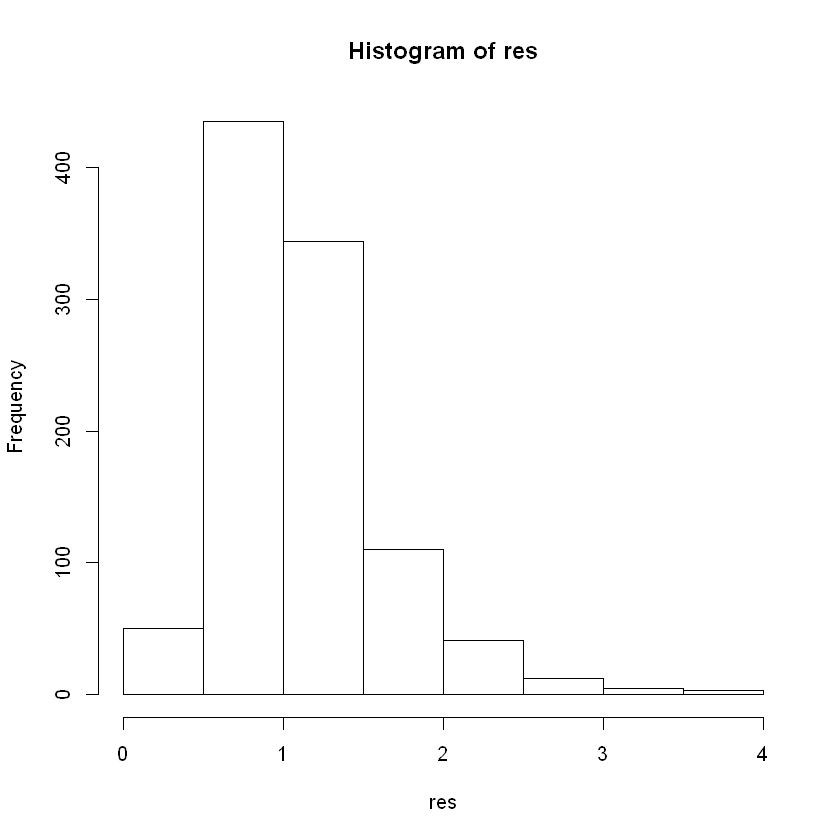

In [36]:
permutation.test(salary1, salary2, function(d1,d2){var(d1)/var(d2)})

显然，这从两个角度以及1%显著性证明了salary1的方差比salary2的大。

我们甚至也可以直接检验中位数

$statistic
[1] -2121

$left.p
[1] 0.03

$right.p
[1] 0.97

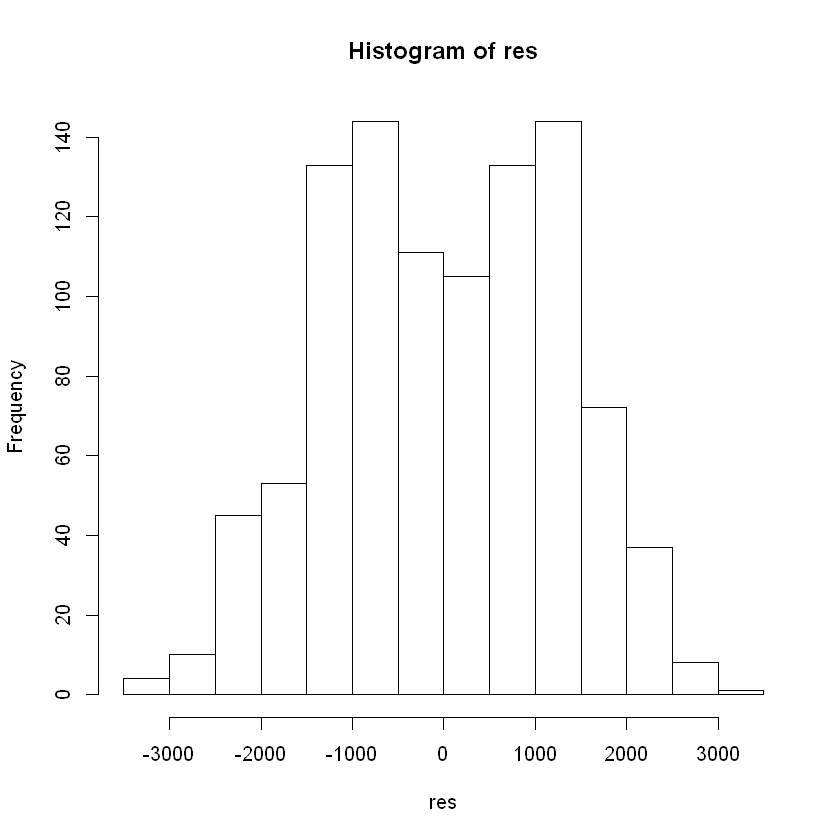

In [37]:
permutation.test(salary1, salary2, function(d1,d2){median(d1) - median(d2)})

permutation test实在太方便了。它几乎可以轻松用在任何双样本问题上。这依赖于双样本那种统计量比较好构造，多样本就不好弄了。
不过我们也可以考虑一个分组的函数而放弃其他分组的处理。这就像wilcoxon 秩和检验中$W_X$与$W_{XY}$统计量的区别。
也可以用那种通过平方差汇总各组如何偏离总体出估计“中心值”的信息之类的方法，如Kruskal-Wallis检验就使用此法。

当然仅就上面问题而言，我们可以（翻到Chapter 3 notebook进行比较）看到permutation test的p值比Brown-Mood和wilcoxon 秩和的p值高，
这暗示着它潜在的低功效性。当然，简单直接的东西效力就会差一些，天下没有免费的午餐。